# Matrix inversion or solve
> Short note on matrix inversion and why to prefer solve. Uses Hilbert matrices!

The short advice is always to solve for $x$ in linear equations $Ax=y$ with (for example) LU-decomposition, and don't do $A^{-1}y$. By why _exactly_?

This post came to be after reading [Why Shouldn't I Invert That Matrix](http://gregorygundersen.com/blog/2020/12/09/matrix-inversion/) by Gregory Gundersen. He does an exellent job on describing matrix inversion, LU-decomposition and (ill) conditioned matrices. I'll repeat some terms here.

The argument is that solving is _faster_ and _more precise_ than inversion:

* LU decomposition requires less floating point operations than (plain) matrix inversion.
* Floating point operations are less precise, so more lead to larger errors.


In this post I use matrices related to polynomial interpolation, including Hilbert matrices. Hilbert matrices are _ill-conditioned_, so we expect that inversion will be bad.


## Precision and floats
I'll not go into the computational complexity, read the above post for a nice explanation. We are not solving symbolically but with 32 (or 64) bit floats. For example $0.1$ cannot be represented as a float: [see this article](https://www.exploringbinary.com/why-0-point-1-does-not-exist-in-floating-point/). The more operations we execute the more potential there is for errors. 

In mathematics both methods are precise if we solve symbolically. In mathematics there is the _condition number_ of matrices, a higher condition number means that small changes in $A$ lead to large changes in $x$. This seems exactly the intuition that we need to explore under what conditions we can expect more errors, and the difference between two methods is more pronounced.

In [67]:
#hide
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from sklearn.datasets import load_diabetes
import math
from numpy.random import default_rng

## Solve $Ax=y$
We can solve $Ax=y$ with the LU-decomposition $A=LU$ and then solve $Lz=x$ and then $Ux = z$. Since $L$ and $U$ are triangular matrices this is straightforward.
With triangular matrices you can start with an equation with one variable, solve it and continue.
There'll always be an equation on a single variable (that you didn't solve yet).

Finding the decomposition is the tricky part. The NumPy function `solve` does this with the method from LAPACK. We create an example from polynomial interpolation of the function $f(x)=x^2$ on the points $\{-\frac{1}{2},0,\frac{1}{2}\}$:

In [2]:
f = lambda x: x**2
x = np.array([-.5, 0., .5])
A = np.vander(x, increasing=True)

For a small number of points this gives the same results:

In [3]:
np.linalg.solve(A, f(x)) -  np.linalg.inv(A) @ f(x)

array([0., 0., 0.])

But for larger matrices it starts to differ:

In [4]:
x = np.linspace(-1, 1, 40)
A = np.vander(x, increasing=True)

In [5]:
np.linalg.solve(A, f(x)) - np.linalg.inv(A) @ f(x)

array([-1.40100652e-01,  1.11382317e-01,  1.00881039e-01,  4.94520867e-01,
        3.78189174e-01, -6.48834908e+00, -3.71602241e+00,  2.78155158e+01,
        9.44989685e+00, -7.18503682e+01, -2.39184816e-01,  1.33213768e+02,
       -2.37054964e+01, -1.84869925e+02,  2.41140115e+01,  1.66567935e+02,
        2.94400070e+00, -6.93285557e+01, -2.55111985e+01,  1.67702176e+00,
        3.48501630e+01, -2.03380240e+01, -3.16823477e+01,  4.88047696e+01,
        1.50645974e+01, -3.87264745e+01,  3.73249968e-01,  1.76218177e+01,
       -2.31686235e+00, -5.51101135e+00, -1.84854387e+00,  4.96125557e-01,
        2.44568978e+00,  1.08034577e+00, -1.51065340e+00, -8.77657212e-01,
        4.59726355e-01,  3.29110196e-01, -5.81216797e-02, -4.90222286e-02])

Also the speeds are different:

In [6]:
%timeit np.linalg.inv(A) @ f(x)

111 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%timeit np.linalg.solve(A, f(x))

93 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Hilbert
The difference between the two method is due to the number of floating point operations and the amount of error introduced. We will show this with the Hilbert matrix as an example. The Hilbert matrix is _ill conditioned_, small changes in the matrix will lead to large changes in the computed output. 

Note that the Vandermonde matrix above is almost the Hilbert matrix.

Define the Hilbert matrix

In [36]:
def Hilbert(n):
    return np.array([ [(1/(i+j-1)) for j in range (1, n+1)] for i in range (1, n+1)])
Hilbert(5)

array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.33333333, 0.25      , 0.2       , 0.16666667, 0.14285714],
       [0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ],
       [0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111]])

The inverse of the Hilbert matrix is known in closed form
(see https://en.wikipedia.org/wiki/Hilbert_matrix):

In [37]:
def Hilbert_inv(n):
    return np.array([ [
        (-1)**(i+j) * (i+j-1) * math.comb(n+i-1, n-j) * math.comb(n+j-1, n-i) * math.comb(i+j-2, i-1)**2
        for j in range (1, n+1)] for i in range (1, n+1)])
Hilbert_inv(5)

array([[     25,    -300,    1050,   -1400,     630],
       [   -300,    4800,  -18900,   26880,  -12600],
       [   1050,  -18900,   79380, -117600,   56700],
       [  -1400,   26880, -117600,  179200,  -88200],
       [    630,  -12600,   56700,  -88200,   44100]])

The inverse of the inverse should be the same as the original:

In [38]:
np.all(np.isclose(Hilbert(10), np.linalg.inv(Hilbert_inv(10))))

True

## Error inversion vs solve
Define the error as the mean squared difference between solving through taking the inverse and solving throuh LU-decomposition:

In [97]:
rng = default_rng()

def error(n):
    # Create the matrix A and solution y
    A = Hilbert(n)
    x = rng.uniform(size=(n,1))
    y = A @ x
    
    # Solve Ax=y
    x_inverse = np.linalg.inv(A)@y
    x_solve = np.linalg.solve(A, y)
    e_inverse = np.mean((x - x_inverse)**2)
    e_solve = np.mean((x - x_solve)**2)
    return np.stack((e_inverse, e_solve))

You can see that the difference is quite pronounced for large $n$ (chart is in log-scale)

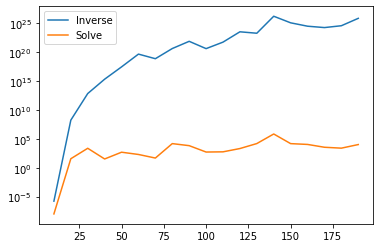

In [104]:
fig, ax =  plt.subplots()
xs = np.arange(10, 200, 10)
ys = [error(x) for x in xs]

series = plt.plot(xs, ys)
plt.legend(iter(series), ('Inverse', 'Solve'))
ax.set_yscale("log", nonpositive='clip')

## Error
Additionally we can look at the quality of the inverse and you can see that the difference increases sharply for larger matrices (chart is in log-scale):

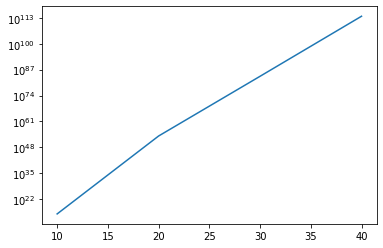

In [58]:
def error_inv(n):
    return np.mean((Hilbert_inv(n) - np.linalg.inv(Hilbert(n)))**2)

fig, ax =  plt.subplots()
xs = np.arange(10, 50, 10)
ys = [error_inv(x) for x in xs]

plt.plot(xs, ys)
ax.set_yscale("log", nonpositive='clip')